# Using global differential privacy with pytorch  in a model that predicts house prices with multiple linear regression.

Using a database from kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview we are going to practice creating a regression model and then applying differential privacy techniques but getting accurate enough results
Libraries: Pandas, numpy, pytorch and scikit-learn.
Steps:
#### 1. Use train dataset as private and partition it for PATE
#### 2. Pick what you think would be some relevant variables to work
#### 3. Create a number of teacher-regression models and then the aggregated teacher.
#### 4. Train a student model with the test data
#### 5. Calculate accuracy
#### 6. Play with another variables, to see improvements of the accuracy 

In [1]:
# Importing libraries
import pandas as pd
import numpy
import torch
import matplotlib.pyplot as plt
# Importing linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset

In [4]:
# Loading training and test dataset
train_data=pd.DataFrame(pd.read_csv('train.csv', engine='python'))

In [5]:
# Preview of the train dataset
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Total area
train_data['TotArea']=train_data['1stFlrSF']+train_data['2ndFlrSF']+train_data['GarageArea']+train_data['TotRmsAbvGrd']

In [7]:
# Selecting the variables that we are going to use in our model
train_data['log_YearRemodAdd']=train_data['YearRemodAdd'].apply(numpy.log)
train_data['log_YearBuilt']=train_data['YearBuilt'].apply(numpy.log)
train_data['log_GrLivArea']=train_data['GrLivArea'].apply(numpy.log)
train_data['log_1stFlrSF']=train_data['1stFlrSF'].apply(numpy.log)
x = train_data[['OverallQual','log_1stFlrSF','TotArea','log_GrLivArea','GarageCars','FullBath','log_YearBuilt','log_YearRemodAdd']]
# Y: Sale price
y = train_data[['SalePrice']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)
# Adding features
poly=PolynomialFeatures(interaction_only=True)
x_train=poly.fit_transform(x_train)
x_test=poly.transform(x_test)
# To normalize
normalizer=StandardScaler()
x_train=normalizer.fit_transform(x_train)
x_test=normalizer.transform(x_test)

## Returning dataloaders for a specified number of teachers.

In [8]:
# Batch size
batch_size=1
# number of teachers to ensemble
num_teachers = 10
# Function to create dataloaders to each teacher classifier
def get_data_loaders(train_data, num_teachers):
    teacher_loaders = []
    data_size = len(train_data) // num_teachers
    for i in range(num_teachers):
        indices = list(range(i*data_size, (i+1) *data_size))
        subset_data = Subset(train_data, indices)
        # load the training data
        trainloader = torch.utils.data.DataLoader(subset_data, batch_size=batch_size)
        teacher_loaders.append(trainloader)
    return teacher_loaders
teacher_loaders = get_data_loaders(x_train, num_teachers)

## Define the students sets

In [9]:
indices_student_trainset=list(range(int(0.9*(len(x_test)))))
indices_student_testset=list(range(int(0.9*(len(x_test))),len(x_test)))
student_train_data = Subset(x_test, indices_student_trainset)
student_test_data = Subset(x_test, indices_student_testset)
student_train_loader = torch.utils.data.DataLoader(student_train_data, batch_size=batch_size)            
student_test_loader = torch.utils.data.DataLoader(student_test_data, batch_size=batch_size) 

## To train a single teacher

In [17]:
# Code for linear regression model
mlr = LinearRegression(normalize=True)
mlr.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [18]:
# Prediction with all test values
print("Test score:")
print(mlr.score(x_test, y_test))

Test score:
0.7801239980891763


In [19]:
# To show how .score calculates the accuracy
y_predict=mlr.predict(x_test)
u=((y_test - y_predict) ** 2).sum()
v=((y_test - y_test.mean()) ** 2).sum()
r_squared=1-(u/v)
r_squared

SalePrice    0.780124
dtype: float64

In [20]:
# Prediction with all training values
print("Training score:")
print(mlr.score(x_train,y_train))

Training score:
0.8650754335077958


In [10]:
# Printing the coefficients of the function
print(mlr.coef_)

[[ 2.26380309e+04  3.68525708e+04  5.91929783e+01 -2.65292592e+04
   7.39513850e+01 -4.94627680e+03  4.53920904e+05  6.31466033e+05]]


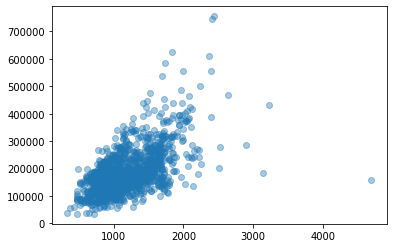

In [11]:
plt.scatter(train_data[['1stFlrSF']], train_data[['SalePrice']], alpha=0.4)

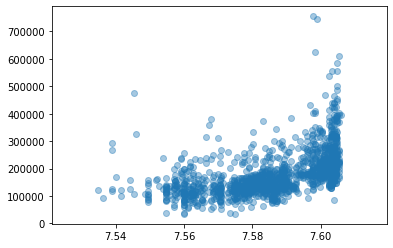

In [12]:
plt.scatter(train_data[['log_YearBuilt']], train_data[['SalePrice']], alpha=0.4)

In [13]:
# Printing correlation matrix
corr_matrix=train_data.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice           1.000000
OverallQual         0.790982
TotArea             0.778212
GrLivArea           0.708624
log_GrLivArea       0.695118
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
log_1stFlrSF        0.591264
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
log_YearBuilt       0.520574
YearRemodAdd        0.507101
log_YearRemodAdd    0.506848
GarageYrBlt         0.486362
MasVnrArea          0.477493
Fireplaces          0.466929
BsmtFinSF1          0.386420
LotFrontage         0.351799
WoodDeckSF          0.324413
2ndFlrSF            0.319334
OpenPorchSF         0.315856
HalfBath            0.284108
LotArea             0.263843
BsmtFullBath        0.227122
BsmtUnfSF           0.214479
BedroomAbvGr        0.168213
ScreenPorch         0.111447
PoolArea            0.092404
MoSold              0.046432
3SsnPorch           0.044584
BsmtFinSF2         -0.011378
BsmtHalfBath  

<function matplotlib.pyplot.show(*args, **kw)>

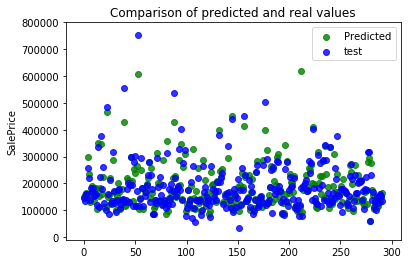

In [21]:
id=range(0,len(y_predict),1)
plt.scatter(id, y_predict, color='green',marker="o",alpha=0.8) 
plt.scatter(id, y_test, color='blue',marker="o",alpha=0.8)
plt.ylabel('SalePrice')
plt.title('Comparison of predicted and real values')
plt.legend(['Predicted', 'test'])
plt.show